In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.avgpool1 = nn.AvgPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.avgpool2 = nn.AvgPool2d(kernel_size=2)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.tanh = nn.Tanh()
        
    def forward(self, x):
        x = self.tanh(self.conv1(x))
        x = self.avgpool1(x)
        x = self.tanh(self.conv2(x))
        x = self.avgpool2(x)
        x = x.view(-1, 16 * 4 * 4)
        x = self.tanh(self.fc1(x))
        x = self.tanh(self.fc2(x))
        x = self.fc3(x)
        return x

class MNISTClassifier:
    def __init__(self, device=None):
        """
        Initialize the MNIST classification system.
        """
        self.device = device if device else torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.class_names = list(range(10))
        
        # Define transforms
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])
        
        # Load MNIST dataset
        self.train_dataset = datasets.MNIST('./data', train=True, download=True, transform=self.transform)
        self.test_dataset = datasets.MNIST('./data', train=False, transform=self.transform)
        
        # Create data loaders
        self.train_loader = DataLoader(self.train_dataset, batch_size=32, shuffle=True)
        self.test_loader = DataLoader(self.test_dataset, batch_size=32, shuffle=False)
        
        # Initialize model
        self.model = LeNet5().to(self.device)
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.001)
        
    def train(self, epochs=10):
        """
        Train the LeNet-5 model.
        """
        history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
        
        for epoch in range(epochs):
            self.model.train()
            train_loss = 0
            correct = 0
            total = 0
            
            for batch_idx, (data, target) in enumerate(self.train_loader):
                data, target = data.to(self.device), target.to(self.device)
                
                self.optimizer.zero_grad()
                output = self.model(data)
                loss = self.criterion(output, target)
                loss.backward()
                self.optimizer.step()
                
                train_loss += loss.item()
                _, predicted = output.max(1)
                total += target.size(0)
                correct += predicted.eq(target).sum().item()
                
            # Calculate training metrics
            train_loss = train_loss / len(self.train_loader)
            train_acc = 100. * correct / total
            
            # Validation phase
            val_loss, val_acc = self.evaluate()
            
            # Store metrics
            history['train_loss'].append(train_loss)
            history['train_acc'].append(train_acc)
            history['val_loss'].append(val_loss)
            history['val_acc'].append(val_acc)
            
            print(f'Epoch: {epoch+1}/{epochs}')
            print(f'Training Loss: {train_loss:.3f} | Training Acc: {train_acc:.2f}%')
            print(f'Val Loss: {val_loss:.3f} | Val Acc: {val_acc:.2f}%')
        
        return history
    
    def evaluate(self):
        """
        Evaluate the model on test data.
        """
        self.model.eval()
        test_loss = 0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for data, target in self.test_loader:
                data, target = data.to(self.device), target.to(self.device)
                output = self.model(data)
                test_loss += self.criterion(output, target).item()
                _, predicted = output.max(1)
                total += target.size(0)
                correct += predicted.eq(target).sum().item()
        
        test_loss = test_loss / len(self.test_loader)
        test_acc = 100. * correct / total
        
        return test_loss, test_acc
    
    def plot_training_history(self, history):
        """
        Plot training and validation accuracy/loss.
        """
        plt.figure(figsize=(12, 4))
        
        # Accuracy subplot
        plt.subplot(1, 2, 1)
        plt.plot(history['train_acc'])
        plt.plot(history['val_acc'])
        plt.title('Model Accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
        
        # Loss subplot
        plt.subplot(1, 2, 2)
        plt.plot(history['train_loss'])
        plt.plot(history['val_loss'])
        plt.title('Model Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
        
        plt.tight_layout()
        plt.show()
    
    def get_predictions(self, loader):
        """
        Get predictions for the entire dataset.
        """
        all_predictions = []
        all_targets = []
        all_probs = []
        
        self.model.eval()
        with torch.no_grad():
            for data, target in loader:
                data = data.to(self.device)
                output = self.model(data)
                probs = torch.nn.functional.softmax(output, dim=1)
                _, predicted = output.max(1)
                
                all_predictions.extend(predicted.cpu().numpy())
                all_targets.extend(target.numpy())
                all_probs.extend(probs.cpu().numpy())
        
        return np.array(all_predictions), np.array(all_targets), np.array(all_probs)
    
    def plot_confusion_matrix(self):
        """
        Plot confusion matrix for the test set predictions.
        """
        predictions, targets, _ = self.get_predictions(self.test_loader)
        
        # Calculate confusion matrix
        cm = confusion_matrix(targets, predictions)
        
        # Plot
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=self.class_names,
                   yticklabels=self.class_names)
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()
        
        # Print classification report
        print("\nClassification Report:")
        print(classification_report(targets, predictions,
                                 target_names=[str(i) for i in self.class_names]))
    
    def visualize_predictions(self, num_images=10):
        """
        Visualize model predictions on test images.
        """
        dataiter = iter(self.test_loader)
        images, labels = next(dataiter)
        images = images[:num_images]
        labels = labels[:num_images]
        
        self.model.eval()
        with torch.no_grad():
            outputs = self.model(images.to(self.device))
            probs = torch.nn.functional.softmax(outputs, dim=1)
            predictions = outputs.max(1)[1]
        
        # Create a grid of images
        plt.figure(figsize=(15, 3))
        for i in range(num_images):
            plt.subplot(1, num_images, i+1)
            plt.imshow(images[i].squeeze(), cmap='gray')
            pred_class = predictions[i].item()
            true_class = labels[i].item()
            confidence = probs[i][pred_class].item() * 100
            plt.title(f'Pred: {pred_class}\nTrue: {true_class}\nConf: {confidence:.1f}%')
            plt.axis('off')
        
        plt.tight_layout()
        plt.show()

    def visualize_layer_outputs(self, image_idx=0):
        """
        Visualize the output of convolutional and pooling layers for a single image.
        
        Args:
            image_idx (int): Index of the test image to visualize
        """
        # Get a single image
        dataiter = iter(self.test_loader)
        images, labels = next(dataiter)
        image = images[image_idx:image_idx+1].to(self.device)
        
        # Dictionary to store outputs
        layer_outputs = {}
        
        # Hook function to capture layer outputs
        def hook_fn(module, input, output):
            layer_outputs[module] = output.cpu().detach()
        
        # Register hooks for conv and pool layers
        hooks = []
        for name, layer in self.model.named_children():
            if isinstance(layer, (nn.Conv2d, nn.AvgPool2d)):
                hooks.append(layer.register_forward_hook(hook_fn))
        
        # Forward pass
        self.model.eval()
        with torch.no_grad():
            _ = self.model(image)
        
        # Remove hooks
        for hook in hooks:
            hook.remove()
        
        # Plot original image and feature maps
        plt.figure(figsize=(15, 12))
        
        # Original image
        plt.subplot(3, 3, 1)
        plt.imshow(images[image_idx].squeeze(), cmap='gray')
        plt.title('Original Image')
        plt.axis('off')
        
        # Plot feature maps
        plot_idx = 2
        for layer, output in layer_outputs.items():
            if isinstance(layer, nn.Conv2d):
                # Get the first few feature maps
                feature_maps = output.squeeze(0)
                num_maps = min(4, feature_maps.size(0))
                
                for i in range(num_maps):
                    plt.subplot(3, 3, plot_idx)
                    plt.imshow(feature_maps[i], cmap='viridis')
                    plt.title(f'{layer.__class__.__name__} \nChannel {i+1}')
                    plt.axis('off')
                    plot_idx += 1
        
        plt.tight_layout()
        plt.show()
        
        # Print model prediction for this image
        with torch.no_grad():
            output = self.model(image)
            prob = F.softmax(output, dim=1)
            pred = output.argmax(dim=1).item()
            true_label = labels[image_idx].item()
            confidence = prob[0][pred].item() * 100
            
        print(f'True Label: {true_label}')
        print(f'Predicted: {pred} (Confidence: {confidence:.2f}%)')
    
    def visualize_misclassified(self, num_images=10):
        """
        Visualize misclassified images with their predicted and true labels.
        
        Args:
            num_images (int): Number of misclassified images to display
        """
        self.model.eval()
        misclassified_images = []
        misclassified_labels = []
        misclassified_preds = []
        misclassified_probs = []
        
        with torch.no_grad():
            for data, target in self.test_loader:
                data, target = data.to(self.device), target.to(self.device)
                output = self.model(data)
                prob = F.softmax(output, dim=1)
                pred = output.argmax(dim=1)
                
                # Find misclassified indices in this batch
                misclassified_mask = pred.ne(target)
                
                if misclassified_mask.any():
                    misclassified_images.extend(data[misclassified_mask].cpu())
                    misclassified_labels.extend(target[misclassified_mask].cpu())
                    misclassified_preds.extend(pred[misclassified_mask].cpu())
                    misclassified_probs.extend(prob[misclassified_mask].cpu())
                
                if len(misclassified_images) >= num_images:
                    break
        
        if not misclassified_images:
            print("No misclassified images found!")
            return
        
        # Convert lists to tensors
        misclassified_images = torch.stack(misclassified_images[:num_images])
        misclassified_labels = torch.stack(misclassified_labels[:num_images])
        misclassified_preds = torch.stack(misclassified_preds[:num_images])
        misclassified_probs = torch.stack(misclassified_probs[:num_images])
        
        # Create a grid of images
        plt.figure(figsize=(15, 3))
        for i in range(min(num_images, len(misclassified_images))):
            plt.subplot(1, num_images, i+1)
            plt.imshow(misclassified_images[i].squeeze(), cmap='gray')
            
            pred_class = misclassified_preds[i].item()
            true_class = misclassified_labels[i].item()
            confidence = misclassified_probs[i][pred_class].item() * 100
            
            plt.title(f'Pred: {pred_class}\nTrue: {true_class}\nConf: {confidence:.1f}%',
                     color='red')
            plt.axis('off')
        
        plt.tight_layout()
        plt.show()
        
        # Print summary statistics
        print("\nMisclassification Analysis:")
        print(f"Total misclassified images found: {len(misclassified_images)}")
        
        # Create confusion pairs
        confusion_pairs = list(zip(misclassified_labels.numpy(), 
                                 misclassified_preds.numpy()))
        pair_counts = {}
        for true, pred in confusion_pairs:
            pair = (true, pred)
            pair_counts[pair] = pair_counts.get(pair, 0) + 1
        
        # Print most common confusion pairs
        print("\nMost common confusion pairs (true -> predicted):")
        for (true, pred), count in sorted(pair_counts.items(), 
                                        key=lambda x: x[1], 
                                        reverse=True)[:5]:
            print(f"  {true} -> {pred}: {count} times")


In [30]:
# Create and train the classifier
mnist_classifier = MNISTClassifier()

# Train the model
history = mnist_classifier.train(epochs=10)


Epoch: 1/10
Training Loss: 0.213 | Training Acc: 93.77%
Val Loss: 0.078 | Val Acc: 97.68%
Epoch: 2/10
Training Loss: 0.067 | Training Acc: 97.96%
Val Loss: 0.063 | Val Acc: 97.92%
Epoch: 3/10
Training Loss: 0.048 | Training Acc: 98.52%
Val Loss: 0.044 | Val Acc: 98.64%
Epoch: 4/10
Training Loss: 0.038 | Training Acc: 98.82%
Val Loss: 0.053 | Val Acc: 98.47%
Epoch: 5/10
Training Loss: 0.031 | Training Acc: 99.02%
Val Loss: 0.054 | Val Acc: 98.33%
Epoch: 6/10
Training Loss: 0.027 | Training Acc: 99.17%
Val Loss: 0.062 | Val Acc: 98.32%
Epoch: 7/10
Training Loss: 0.022 | Training Acc: 99.28%
Val Loss: 0.040 | Val Acc: 98.76%
Epoch: 8/10
Training Loss: 0.019 | Training Acc: 99.39%
Val Loss: 0.038 | Val Acc: 98.89%
Epoch: 9/10
Training Loss: 0.017 | Training Acc: 99.44%
Val Loss: 0.045 | Val Acc: 98.72%
Epoch: 10/10
Training Loss: 0.014 | Training Acc: 99.55%
Val Loss: 0.044 | Val Acc: 98.78%


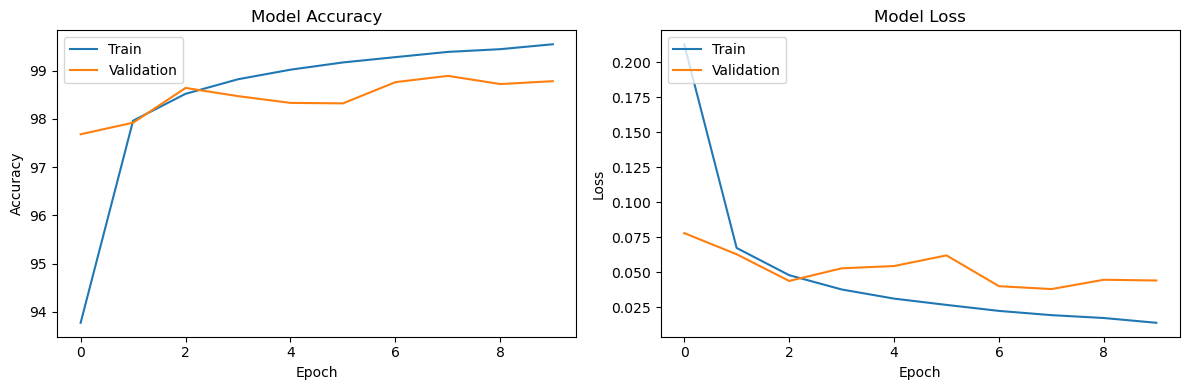

In [31]:
# Plot training history
mnist_classifier.plot_training_history(history)


In [32]:
# Evaluate the model
test_loss, test_accuracy = mnist_classifier.evaluate()
print(f"Test accuracy: {test_accuracy:.2f}%")


Test accuracy: 98.78%


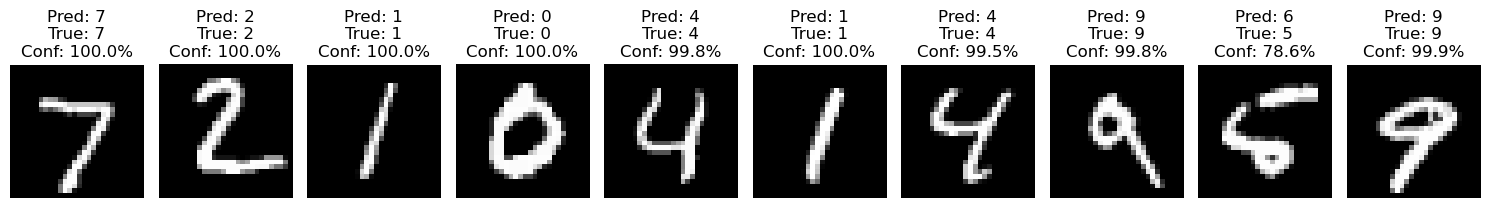

In [33]:
# Visualize predictions
mnist_classifier.visualize_predictions()

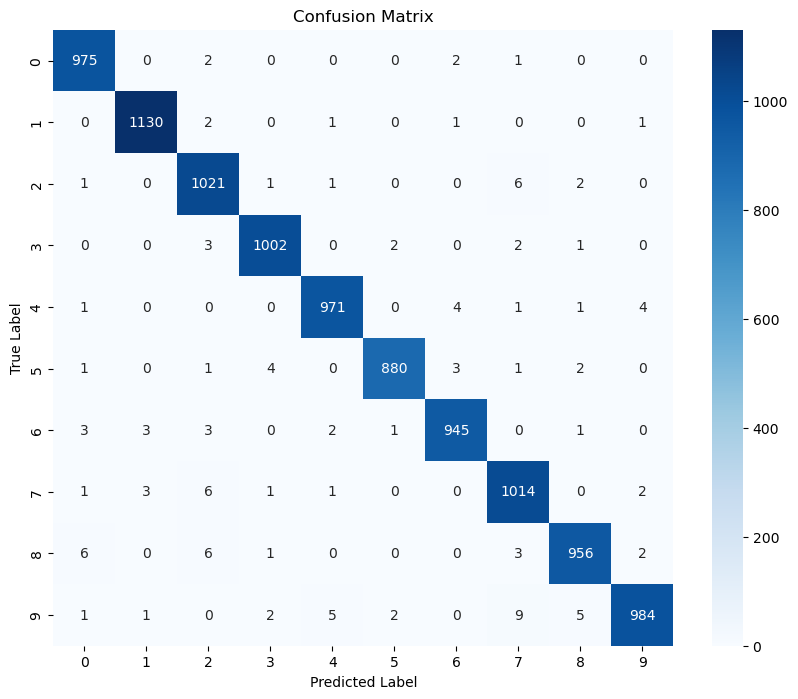


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      1.00      0.99      1135
           2       0.98      0.99      0.98      1032
           3       0.99      0.99      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       0.99      0.99      0.99       958
           7       0.98      0.99      0.98      1028
           8       0.99      0.98      0.98       974
           9       0.99      0.98      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



In [34]:
# Visualizations
mnist_classifier.plot_confusion_matrix()


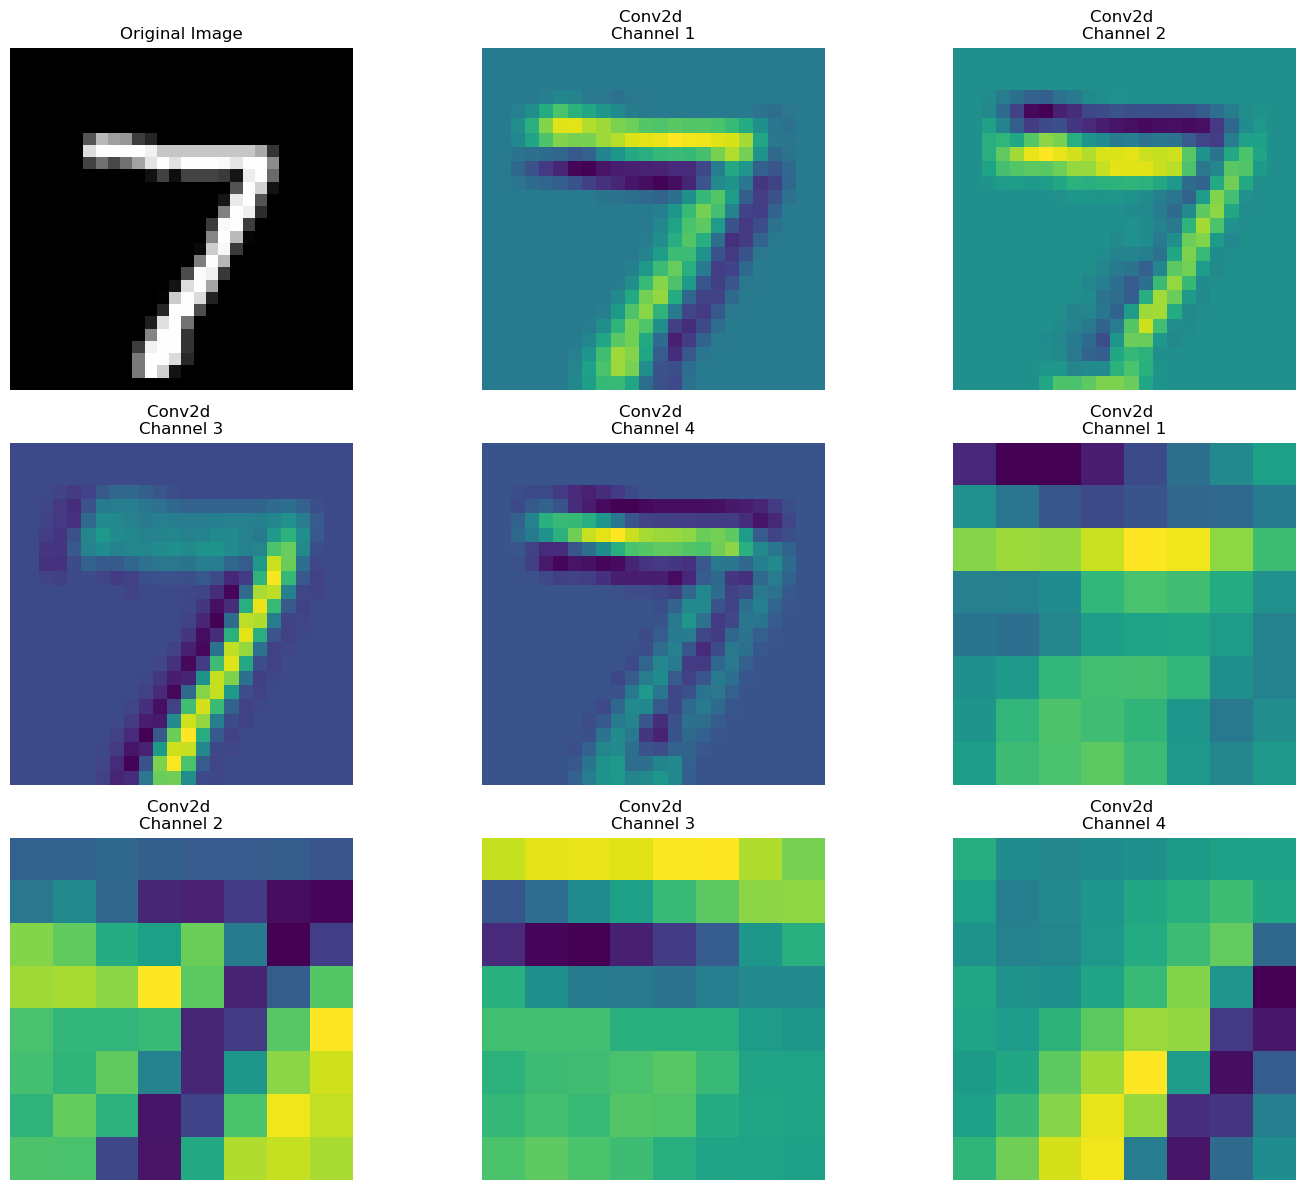

True Label: 7
Predicted: 7 (Confidence: 100.00%)


In [35]:
mnist_classifier.visualize_layer_outputs()

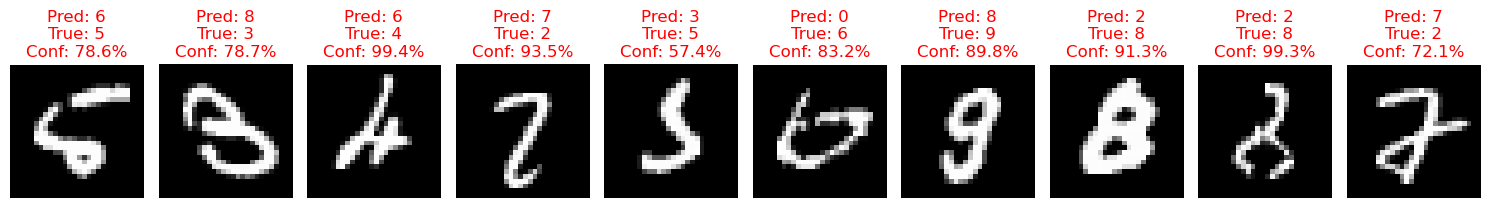


Misclassification Analysis:
Total misclassified images found: 10

Most common confusion pairs (true -> predicted):
  2 -> 7: 2 times
  8 -> 2: 2 times
  5 -> 6: 1 times
  3 -> 8: 1 times
  4 -> 6: 1 times


In [36]:
mnist_classifier.visualize_misclassified()